In [1]:
import numpy as np
from pandas import pandas as pd
import time
import copy
from pprint import pprint

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### Random dataframe

In [2]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

dt = pd.read_csv("dataset_with_labels.csv", engine='python').drop('Unnamed: 0',axis=1).reset_index(drop=True)
data = copy.copy(dt)
data.head()

,subject_id,icustay_id,creatinine,age,arterial_pressure_systolic,arterial_pressure_systolic_delay,arterial_pressure_diastolic,arterial_pressure_diastolic_delay,heart_rate,heart_rate_delay,...,bilirubin,bilirubin_delay,c_reactive_protein,c_reactive_protein_delay,ethnicity,diagnosis,gender,creatinine_yesterday,creatinine_before_yesterday,label
0,77815,239231,0.6,58.363217,155.0,1800.0,75.0,1800.0,58.0,1800.0,...,NaN,NaN,NaN,NaN,WHITE,INTRACRANIAL HEMORRHAGE,M,0.7,0.6,2.0
1,77815,239231,0.6,58.363217,155.0,1800.0,75.0,1800.0,58.0,1800.0,...,NaN,NaN,NaN,NaN,WHITE,INTRACRANIAL HEMORRHAGE,M,NaN,0.7,2.0
2,31558,249349,0.6,52.688716,165.0,1440.0,75.0,1440.0,102.0,1440.0,...,NaN,NaN,NaN,NaN,WHITE,S/P BOATING ACCIDENT,M,NaN,NaN,2.0
3,31558,249349,0.6,52.688716,165.0,1440.0,75.0,1440.0,102.0,1440.0,...,NaN,NaN,NaN,NaN,WHITE,S/P BOATING ACCIDENT,M,0.7,0.7,0.0
4,31558,249349,0.6,52.688716,165.0,1440.0,75.0,1440.0,102.0,1440.0,...,NaN,NaN,NaN,NaN,WHITE,S/P BOATING ACCIDENT,M,0.6,0.6,2.0


In [3]:
data = dt
min_max_scaler = preprocessing.MinMaxScaler()

# Features to use
feat_names_num = ['creatinine', 
#                   'creatinine_yesterday', 
#                   'creatinine_before_yesterday',
                  'arterial_pressure_systolic',  
                  'age', 
                  'arterial_pressure_diastolic',
                  'heart_rate',  
                  'weight_daily', 
                  'temperature',  
                  'ph_blood']

feat_names_cat = ['gender', 'ethnicity', 'diagnosis']
feat_names = feat_names_num + feat_names_cat

# feat_names = feat_names + ['arterial_pressure_systolic_delay', 'arterial_pressure_diastolic_delay',
#                            'heart_rate_delay', 'weight_daily_delay', 'temperature_delay']

feat_lab = feat_names + ['label']

print('Initial data length: ', len(data))
data = data[feat_lab]

# Remove outliers
data = data[data['creatinine'] < 20]
# data = data[data['creatinine_yesterday'] < 20]
# data = data[data['creatinine_before_yesterday'] < 20]
# data = data[data['potassium'] > 1.2]
data = data[data['ph_blood'] > 6]
data = data[data['age'] < 110]
# data = data[data['bilirubin'] < 20]
data['gender'] = data['gender'].map({'F': 1, 'M': 0})

# Remove Nan
for name in feat_names:
    try:
        data = data[np.isfinite(data[name])]
    except:
        data = data[data[name].isnull() == False]

print('\nTotal entries: ', len(data))

# Normalize data
data[feat_names_num] = (data[feat_names_num] - 
                        data[feat_names_num].mean()) / (data[feat_names_num].max() - 
                                                        data[feat_names_num].min())
print(data.head())
print(data.isnull().sum())

Initial data length:  36251

Total entries:  20248
   creatinine  arterial_pressure_systolic       age  \
2   -0.062261                    0.143587 -0.145735   
3   -0.062261                    0.143587 -0.145735   
4   -0.062261                    0.143587 -0.145735   
5   -0.062261                    0.143587 -0.145735   
6   -0.062261                    0.143587 -0.145735   

   arterial_pressure_diastolic  heart_rate  weight_daily  temperature  \
2                      0.00023    0.101697      0.031566     0.000182   
3                      0.00023    0.101697      0.031566     0.000182   
4                      0.00023    0.101697      0.031566     0.000182   
5                      0.00023    0.101697      0.031566     0.000182   
6                      0.00023    0.101697      0.031566     0.000182   

   ph_blood  gender ethnicity             diagnosis  label  
2 -0.184757       0     WHITE  S/P BOATING ACCIDENT    2.0  
3 -0.184757       0     WHITE  S/P BOATING ACCIDENT    0.

In [4]:
data['ethnicity'].unique()



data['ethnicity'] = data['ethnicity'].map({'BLACK/AFRICAN AMERICAN': 'BLACK', 
                                           'WHITE': 'WHITE', 
                                           'UNKNOWN/NOT SPECIFIED': 'NaN',
                                           'HISPANIC/LATINO - DOMINICAN': 'OTHER', 
                                           'UNABLE TO OBTAIN': 'NaN',
                                           'PATIENT DECLINED TO ANSWER': 'NaN', 
                                           'ASIAN - CHINESE': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER', 
                                           'MULTI RACE ETHNICITY': 'OTHER',
                                           'WHITE - OTHER EUROPEAN': 'WHITE', 
                                           'OTHER': 'OTHER', 
                                           'PORTUGUESE': 'WHITE',
                                           'HISPANIC OR LATINO': 'OTHER', 
                                           'ASIAN': 'ASIAN', 
                                           'HISPANIC/LATINO - PUERTO RICAN': 'OTHER',
                                           'MIDDLE EASTERN': 'OTHER', 
                                           'ASIAN - KOREAN': 'ASIAN', 
                                           'BLACK/HAITIAN': 'BLACK',
                                           'ASIAN - OTHER': 'ASIAN', 
                                           'HISPANIC/LATINO - CUBAN': 'OTHER', 
                                           'ASIAN - FILIPINO': 'ASIAN',
                                           'BLACK/CAPE VERDEAN': 'BLACK', 
                                           'WHITE - BRAZILIAN': 'WHITE', 
                                           'ASIAN - ASIAN INDIAN': 'ASIAN',
                                           'WHITE - EASTERN EUROPEAN': 'WHITE', 
                                           'HISPANIC/LATINO - GUATEMALAN': 'OTHER',
                                           'ASIAN - VIETNAMESE': 'ASIAN', 
                                           'HISPANIC/LATINO - MEXICAN': 'OTHER',
                                           'WHITE - RUSSIAN': 'WHITE', 
                                           'BLACK/AFRICAN': 'BLACK', 
                                           'ASIAN - CAMBODIAN': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'OTHER'})
data['ethnicity'].unique()
data.tail()

,creatinine,arterial_pressure_systolic,age,arterial_pressure_diastolic,heart_rate,weight_daily,temperature,ph_blood,gender,ethnicity,diagnosis,label
35052,0.236884,-0.108114,0.059917,-0.000165,0.358642,-0.003322,-0.000625,-0.238090,0,WHITE,PROSTATE CANCER/SDA,0.0
35053,-0.028073,0.031342,0.248162,-0.000684,0.066975,-0.002871,-0.000322,-0.171424,1,WHITE,ABDOMINAL PAIN; HYPOTENSION,1.0
35054,0.031756,0.085764,0.129691,-0.000289,-0.092747,0.051114,0.000485,0.001910,0,WHITE,HYPERTENSION,1.0
35059,0.006115,-0.060495,-0.006608,-0.000352,-0.002469,0.002242,0.000384,-0.211424,0,WHITE,FOURNIER'S GANGRENE,0.0
35060,0.031756,-0.087706,0.155149,-0.000372,-0.106636,0.050513,-0.000019,-0.038090,1,WHITE,CRITITCAL AORTIC STENOSIS,0.0


In [5]:
len(data['diagnosis'].unique())
diag_to_stay = ['PNEUMONIA', 'CONGESTIVE HEART FAILURE', 'SUBARACHNOID HEMORRHAGE',
               'INTRACRANIAL HEMORRHAGE', 'ALTERED MENTAL STATUS', 'CORONARY ARTERY DISEASE',
               'ABDOMINAL PAIN', 'CHEST PAIN', 'HYPOTENSION', 'ACUTE RENAL FAILURE',
               'RESPIRATORY FAILURE', 'GASTROINTESTINAL BLEED', 'PANCREATITIS', 'SEPSIS']
'YS' in data['diagnosis'].iloc[1]
for i in range(len(data['diagnosis'])):
    value = data['diagnosis'].iat[i]
    if 'FEVER' in value:
        data['diagnosis'].iat[i] = 'SEPSIS'
    elif 'DYSPNEA' in value or 'SHORTNESS OF BREATH' in value:
        data['diagnosis'].iat[i] = 'RESPIRATORY FAILURE'
    elif value not in diag_to_stay:
        data['diagnosis'].iat[i] = 'OTHER'
data['diagnosis'].unique()

array(['OTHER', 'SEPSIS', 'PNEUMONIA', 'PANCREATITIS',
       'INTRACRANIAL HEMORRHAGE', 'SUBARACHNOID HEMORRHAGE',
       'ABDOMINAL PAIN', 'CONGESTIVE HEART FAILURE', 'HYPOTENSION',
       'CHEST PAIN', 'CORONARY ARTERY DISEASE', 'ALTERED MENTAL STATUS',
       'RESPIRATORY FAILURE', 'GASTROINTESTINAL BLEED',
       'ACUTE RENAL FAILURE'], dtype=object)

In [6]:
print(feat_names)
data = pd.get_dummies(data)
data.head()

['creatinine', 'arterial_pressure_systolic', 'age', 'arterial_pressure_diastolic', 'heart_rate', 'weight_daily', 'temperature', 'ph_blood', 'gender', 'ethnicity', 'diagnosis']


,creatinine,arterial_pressure_systolic,age,arterial_pressure_diastolic,heart_rate,weight_daily,temperature,ph_blood,gender,label,...,diagnosis_CORONARY ARTERY DISEASE,diagnosis_GASTROINTESTINAL BLEED,diagnosis_HYPOTENSION,diagnosis_INTRACRANIAL HEMORRHAGE,diagnosis_OTHER,diagnosis_PANCREATITIS,diagnosis_PNEUMONIA,diagnosis_RESPIRATORY FAILURE,diagnosis_SEPSIS,diagnosis_SUBARACHNOID HEMORRHAGE
2,-0.062261,0.143587,-0.145735,0.00023,0.101697,0.031566,0.000182,-0.184757,0,2.0,...,0,0,0,0,1,0,0,0,0,0
3,-0.062261,0.143587,-0.145735,0.00023,0.101697,0.031566,0.000182,-0.184757,0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,-0.062261,0.143587,-0.145735,0.00023,0.101697,0.031566,0.000182,-0.184757,0,2.0,...,0,0,0,0,1,0,0,0,0,0
5,-0.062261,0.143587,-0.145735,0.00023,0.101697,0.031566,0.000182,-0.184757,0,2.0,...,0,0,0,0,1,0,0,0,0,0
6,-0.062261,0.143587,-0.145735,0.00023,0.101697,0.031566,0.000182,-0.184757,0,0.0,...,0,0,0,0,1,0,0,0,0,0


### Split data to train and test sets

In [7]:
y = data['label']
feat_names = list(data)
feat_names.remove('label')
X = data[feat_names]
X.head()

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Split to three test sets
test_size = len(X_valid_test) // 2
X_validation = X_valid_test[0:test_size]
y_validation = y_valid_test[0:test_size]

X_test = X_valid_test[test_size:-1]
y_test = y_valid_test[test_size:-1]

### Process data for the keras model

In [8]:
# Prepare the data for the keras model
X_train_keras = np.array(X_train)[:,:]
X_train_keras = X_train_keras.astype('float32')
X_validation_keras = np.array(X_validation)[:,:]
X_validation_keras = X_validation_keras.astype('float32')
X_test_keras = np.array(X_test)[:,:]
X_test_keras = X_test_keras.astype('float32')

n_classes = 3
y_train_keras = keras.utils.to_categorical(y_train,n_classes)
y_validation_keras = keras.utils.to_categorical(y_validation,n_classes)
y_test_keras = keras.utils.to_categorical(y_test,n_classes)

# VERY IMPORTANT
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = dict(enumerate(class_weight))

print("CHECK DATA")
print("Shape of X:", X_train_keras.shape)
print("\nShape of y:", y_train_keras.shape)
print("\nFirst 10 rows of X")
print(X_train_keras[:10, :4])
print("\nFirst 10 rows of y")
print(y_train_keras[:10])

CHECK DATA
Shape of X: (16198, 29)

Shape of y: (16198, 3)

First 10 rows of X
[[-2.8072838e-02  9.2566296e-02  1.4204320e-01  2.2552604e-05]
 [ 2.6252544e-01 -2.3079965e-02 -6.3207194e-02 -1.6454591e-04]
 [ 3.1756222e-02 -1.4212759e-01  2.6043543e-01 -5.5953168e-04]
 [ 1.4286733e-01  7.5559489e-02  5.4104373e-02 -1.2296847e-04]
 [-4.5166854e-02  1.5719214e-01 -4.0517054e-02  2.0965112e-04]
 [-1.0978820e-02 -2.6481325e-02  1.8585056e-01 -2.4770081e-04]
 [-6.2260870e-02  3.4743164e-02 -1.1075336e-01  2.2552604e-05]
 [-2.4318113e-03 -7.7501737e-02 -4.3569244e-02  1.6807368e-04]
 [-2.4318113e-03  1.4018534e-01  3.2165053e-01  2.2552604e-05]
 [-5.3713862e-02  4.1309195e-03 -9.8385602e-02  6.8779179e-04]]

First 10 rows of y
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


### Model architecture

In [9]:
# Use only when wanting to optimize the SGD optimizer
# from keras.optimizers import SGD 

def create_model(neurons = [128, 64, 3],
                 dropout_rate=0.1, 
                 weight_constraint=0, 
                 init_mode='uniform',
                 optimizer='Adadelta',
                 # Sigmoid is the recommended activation 
                 # for multiclass classification problems
                 # (at least in the final layer)
                 activation = ['relu', 'relu', 'relu']):

    # Build the model architecture 
    model = Sequential()
    model.add(Dense(neurons[0], 
                    activation=activation[0], 
                    input_shape=(X_train_keras.shape[1],)))
    
                    # Uncomment to optimize dropout (don't forget to comment the previous activation variable)
                    # kernel_initializer='uniform', 
                    # activation='linear', 
                    # kernel_constraint=maxnorm(weight_constraint)))
                    
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons[1], activation=activation[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons[2], activation=activation[2]))

    # Use only when wanting to optimize the SGD optimizer (set optimizer=optimizer in model.compile())
    # optimizer = SGD(lr=learn_rate, momentum=momentum) 
    
    # Compile the model using a loss function and an optimizer.
    # 'sparse_categorical_crossentropy' is mandatory for multiclass classification!
    model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

### Model performance (Grid search)

In [10]:
# Uncomment according to which hyperparameters are necessary to be explored.

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters

# Use only to optimize SGD
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3] 
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

# The most basic parameters to optimize
batch_size = [10]
epochs = [30]

# Use to optimize number of neurons in layers
neurons = [[32, 16, 3]] #[[256, 128, 3], [128, 64, 3], [64, 32, 3], [32, 16, 3]]

# Optimize activation
activation = [['relu', 'relu', 'sigmoid']]#, ['relu', 'relu', 'softmax']] #[['relu', 'relu', 'sigmoid'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'softmax']]

# Use to optimize dropout
# weight_constraint = [1, 3]#[1, 2, 3, 4, 5] 
# dropout_rate = [0.0, 0.5]#[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Use to optimize the optimizer
# optimizer = ['SGD', 
#              'RMSprop', 
#              'Adagrad', 
#              'Adadelta', 
#              'Adam', 
#              'Adamax', 
#              'Nadam']

# Use to optimize initialization of weights
# init_mode = ['uniform', 
#              'lecun_uniform', 
#              'normal', 
#              'zero', 
#              'glorot_normal', 
#              'glorot_uniform', 
#              'he_normal', 
#              'he_uniform']

# Uncomment to optimize extra parameters
param_grid = dict(batch_size=batch_size, 
                  neurons=neurons,
                  activation=activation,
                  # weight_constraint=weight_constraint,
                  # dropout_rate=dropout_rate,
                  # optimizer=optimizer,
                  # init_mode=init_mode,
                  epochs=epochs)
                
# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5, average = 'weighted')

# Perform grid search on the model
cv_sets = StratifiedShuffleSplit(n_splits=3, 
                                 test_size=0.1, 
                                 train_size=None, 
                                 random_state=seed)

start = time.time()

grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    fit_params={'class_weight': class_weight}, # VERY IMPORTANT 
                    # scoring=scorer,  
                    n_jobs=1, #-1
                    cv=cv_sets) 

grid_fit = grid.fit(X = X_train_keras, y = y_train)

end = time.time()
print("\nTime elapsed: ", (end - start)/60, " min")


Time elapsed:  11.215909099578857  min


In [11]:
# Get the estimator
best_clf = grid_fit.best_estimator_

# Summarize results
print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))
means = grid_fit.cv_results_['mean_test_score']
stds = grid_fit.cv_results_['std_test_score']
params = grid_fit.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.618107 using {'epochs': 30, 'activation': ['relu', 'relu', 'sigmoid'], 'batch_size': 10, 'neurons': [32, 16, 3]}
0.618107 (0.007583) with: {'epochs': 30, 'activation': ['relu', 'relu', 'sigmoid'], 'batch_size': 10, 'neurons': [32, 16, 3]}


### Performance on the validation set

In [12]:
bst = best_clf

# Make predictions using the unoptimized and model
best_predictions = grid_fit.predict(X_validation_keras)

print("\nBest classifier: \n", grid_fit)
conf = confusion_matrix(y_validation, best_predictions)
print("\nConfusion matrix")
pprint(conf)

print("\nClassification report")
print(classification_report(y_validation, best_predictions))


Best classifier: 
 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.1,
            train_size=None),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1105613c8>,
       fit_params={'class_weight': {0: 1.9436045116390688, 1: 1.6638931689779148, 2: 0.5306470106470107}},
       iid=True, n_jobs=1,
       param_grid={'epochs': [30], 'activation': [['relu', 'relu', 'sigmoid']], 'batch_size': [10], 'neurons': [[32, 16, 3]]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Confusion matrix
array([[  5, 226, 120],
       [ 12, 290,  84],
       [ 27, 316, 945]])

Classification report
             precision    recall  f1-score   support

        0.0       0.11      0.01      0.03       351
        1.0       0.35      0.75      0.48       386
        2.0       0.82      0.73      0.78      1288

avg / total       0.61      0.61      0.59      2025



### Final test set

In [13]:
best_predictions_test = best_clf.predict(X_test_keras)
conf = confusion_matrix(y_test, best_predictions_test)

print("Confusion matrix")
pprint(conf)

print("\nClassification report")
print(classification_report(y_test, best_predictions_test))

Confusion matrix
array([[  7, 244, 125],
       [ 16, 316,  85],
       [ 31, 289, 911]])

Classification report
             precision    recall  f1-score   support

        0.0       0.13      0.02      0.03       376
        1.0       0.37      0.76      0.50       417
        2.0       0.81      0.74      0.77      1231

avg / total       0.60      0.61      0.58      2024



### Principal component analysis

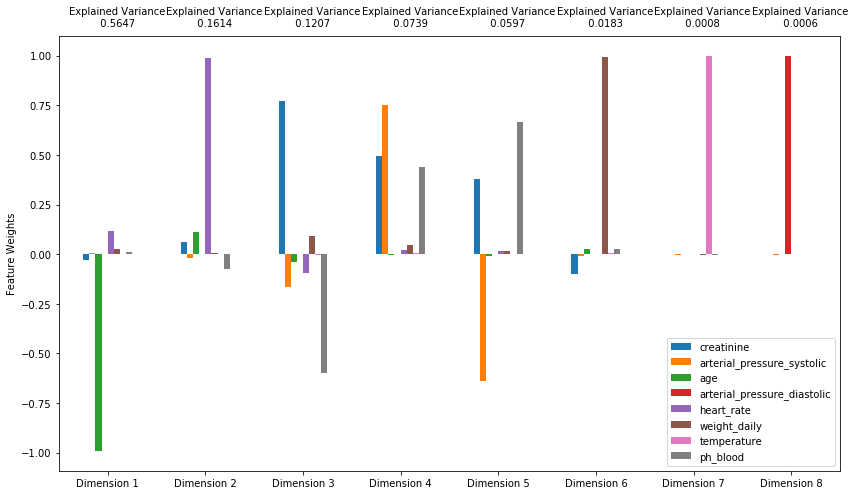

In [14]:
from sklearn.decomposition import PCA
import visuals as vs

pca = PCA(n_components = X[feat_names_num].shape[1], random_state= 42).fit(X[feat_names_num])

pca_results = vs.pca_results(X[feat_names_num], pca)